# Birds classification

1. [Introduction](#introduction)  
1.1. [Objectives](#objectives)  
1.2. [Requirements](#requirements)  
1.3. [Dataset](#dataset)  

2. [Data Analysis](#data)  
2.1. [Imports](#imports)  
2.2. [Loading images](#loading_data)  
2.3. [Data cleaning](#data_cleaning)  

3. [EDA](#eda)

4. [Data Spliting](#split)

5. [Models](#models)  
5.1. [Few-Shots Classification](#few)  
5.2. [Classification Using Pre-trained Architecture With Fine-Tuning](#pretrained)  
5.3. [Few-Shots Classification and Classification with Fine-Tuning Comparison](#comparison)  
5.4. [Understand Classifier with LIME](#line)  

6. [Conclusion](#conclusion)

<a id="introduction"></a>
# 1. Introduction

<a id="objectives"></a>
## 1.1. Objectives

1. Data Cleaning:
   - Remove duplicates and corrupted images from the dataset to ensure that the model learns from high-quality data, avoiding biases or overfitting due to repeated or faulty images.

2. Exploratory Data Analysis (EDA):
   - Conduct EDA on the image dataset, focusing on analyzing the distribution of images and class distribution. This will help in understanding the dataset's characteristics, identifying potential issues (such as imbalance), and guiding further preprocessing steps.

3. Data Splitting:
   - Simulate a real-world scenario where only a few labeled images are available. The dataset will be split into labeled and unlabeled subsets to mimic a few-shot learning environment, which is useful for training in situations with limited labeled data.

4. Transfer Learning with Few-Shot Learning:
   - Apply few-shot learning techniques to train models using limited labeled data. This will allow us to explore how well models can generalize from only a few examples per class.

5. Transfer Learning on Popular Image Classifier Architectures:
   - Practice using transfer learning techniques on popular image classification architectures like ResNet, leveraging pre-trained models and fine-tuning them on the bird species dataset for classification tasks.

6. Evaluating Model Performance:
   - Evaluate the model's performance and analyze its strengths and weaknesses when making predictions. This includes using techniques like LIME for model interpretability and understanding which parts of the image contribute most to predictions, as well as identifying potential failure cases.

<a id="requirements"></a>
## 1.2. Requirements

- Download Data for Bird Species Classification:  
  Download the dataset containing bird species images for the classification task. The dataset should be organized into labeled and unlabeled subsets, where a small number of images are initially labeled for training purposes.

- Conduct EDA on Images:  
  Perform Exploratory Data Analysis (EDA) on the bird species dataset to explore the characteristics of the images. Visualize the class distribution, image size distributions, and potential imbalances in the dataset. This will provide insight into the dataset's structure and help identify any areas that may need attention before model training.

- Adjust Dataset for Few-Shot Learning Scenario:  
  Modify the dataset to simulate a real-world scenario where only a limited number of labeled images are available for each class. The initial training data should consist of no more than 5 images per class to mimic a few-shot learning setup, where the model needs to learn from a small number of labeled examples. Combine the original validation and test datasets, as they will be used as the test dataset for final evaluation.

- Build a Few-Shot Classifier:  
  Implement a few-shot learning technique using the modified dataset. The model should be capable of learning from a small number of labeled examples per class and making predictions for the unlabeled data. Use techniques like Prototypical Networks or Matching Networks to build the classifier.

- Improve Labels by Verifying Predictions:  
  After training the few-shot model, review the best predictions. Visually compare the predicted labels for images with the actual images from the training set. If the predictions are correct, include these images in the labeled training set for further model improvement. This iterative process should be repeated until the model achieves at least 70% accuracy on the combined test dataset.

- Train Classifier Using Pre-trained Architecture:  
  Once a reasonable number of labeled samples are collected (either through few-shot learning or manual labeling), use a pre-trained model (e.g., ResNet, VGG, or EfficientNet) to train the classifier. Fine-tune the model using the labeled dataset, adjusting both the classifier head and the pre-trained backbone to optimize the model for bird species classification.

- Evaluate Model Performance on Test Dataset:  
  Evaluate both the few-shot and fine-tuned models on the combined test dataset. Compare their performance, noting the differences in accuracy, precision, recall, and other metrics. This will help assess the effectiveness of few-shot learning versus fine-tuned transfer learning on the dataset.

- Use LIME to Explain Model Predictions:  
  Apply the LIME (Local Interpretable Model-agnostic Explanations) technique to explain the predictions of the models, especially the best and worst-performing predictions. Use LIME to understand which parts of the image the models are focusing on when making their predictions, and identify potential issues where the model might be relying on irrelevant features.



<a id="dataset"></a>
## 1.3. Dataset

This project focuses on classifying bird species using the NABirds dataset, which provides a comprehensive set of annotated photographs of bird species found in North America. The dataset can be accessed at:  
[NABirds Dataset](https://datasets.activeloop.ai/docs/ml/datasets/nabirds-dataset/).

#### Dataset Overview
- The NABirds dataset contains a collection of 48,000 annotated photographs across 400 bird species commonly found in North America.
- It includes separate annotations for different categories such as males, females, and juveniles, resulting in a total of 700 visual categories.
- Each image in the dataset is accompanied by labels identifying the bird species, as well as bounding boxes that localize the bird in the image.
- The dataset is designed for bird classification tasks and comes with detailed annotations to help improve the performance of machine learning models in identifying and classifying bird species.

#### Data Fields
- images: Tensor containing the face image of birds.
- labels: Tensor containing the labels of bird species categories.
- boxes: Tensor to localize the bird within the image.

#### Data Splits
- Training Set: The training set consists of 23,938 images for training the models.
- Validation Set: The validation set consists of 24,633 images for model evaluation.

The dataset provides a rich source of images with varied bird species, making it ideal for training and evaluating models on bird classification tasks.


<a id="data"></a>
# 2. Data Analysis

<a id="imports"></a>
## 2.1. Imports

In [ ]:
import os
import warnings
import numpy as np
import deeplake
import imagehash
from PIL import Image
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from utils.custom_task_sampler import CustomTaskSampler
from utils.deeplake_few_shot_dataset import DeepLakeFewShotDataset
from torchvision.models import resnet18
import torch.nn.functional as F
from torch import nn, optim
from lime import lime_image
from skimage.segmentation import mark_boundaries

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

<a id="loading_data"></a>
## 2.2. Loading images

In [2]:
ds_train = deeplake.load("hub://activeloop/nabirds-dataset-train")

|

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nabirds-dataset-train



/

hub://activeloop/nabirds-dataset-train loaded successfully.



In [3]:
ds_test = deeplake.load("hub://activeloop/nabirds-dataset-val")

/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nabirds-dataset-val



\

hub://activeloop/nabirds-dataset-val loaded successfully.



<a id="data_cleaning"></a>
## 2.3. Data cleaning

### Check for Duplicates

For that will use image hashing and will check only for training image set, because in model training is most important to have duplicates free.

In [4]:
def compute_image_hash(image: np.ndarray) -> imagehash.ImageHash:
    """
    Compute the perceptual hash (p-hash) of an image.

    Args:
        image (numpy.ndarray): The input image as a NumPy array.

    Returns:
        imagehash.ImageHash: The perceptual hash of the image.
    """
    pil_image = Image.fromarray(image)
    return imagehash.phash(pil_image)


hashes = defaultdict(list)

duplicates = []

for i in range(len(ds_train.images)):
    image = ds_train.images[i].numpy()
    img_hash = compute_image_hash(image)

    if len(hashes[img_hash]) > 0:
        duplicates.append(i)
        hashes[img_hash].append(i)
    else:
        hashes[img_hash].append(i)

print(f"Found {len(duplicates)} duplicates!")

Found 78 duplicates!


There is 78 hash duplication. But different images can have same hash, so next have to check comparing by pixel.

### Check for Duplicates Pixel-Based Comparison

Additional steps:
- resize to 8*8
- allow tolerance in pixel comparison

Image duplicates:


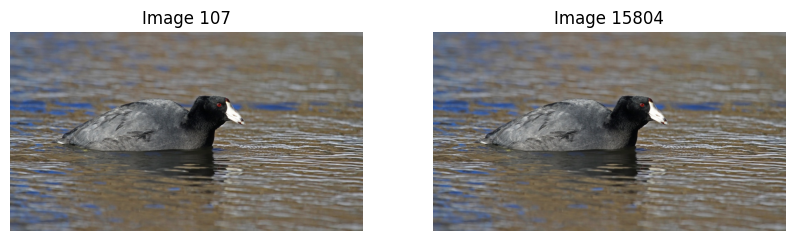

Image duplicates:


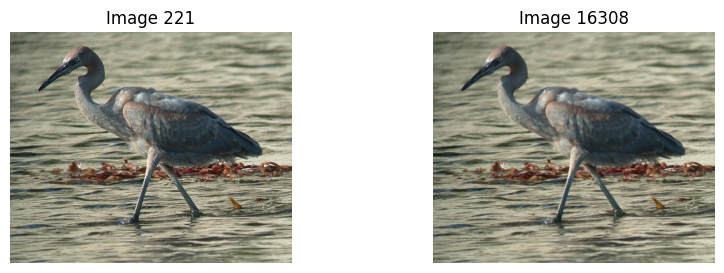

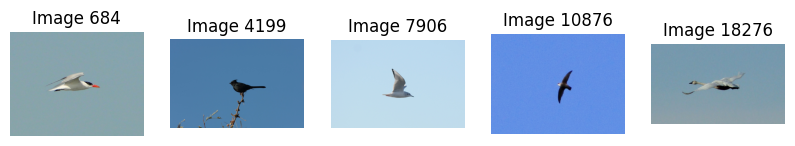

Image duplicates:


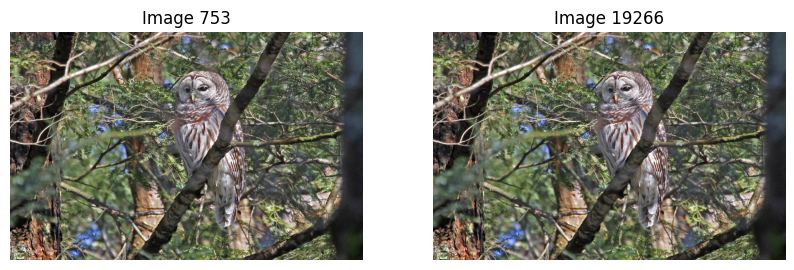

Image duplicates:


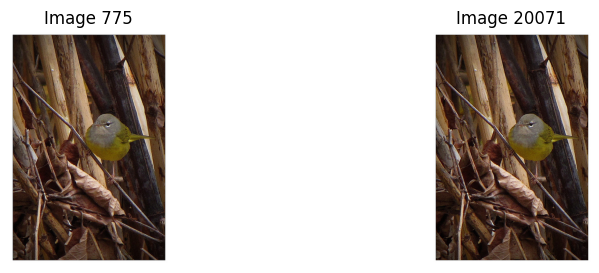

Image duplicates:


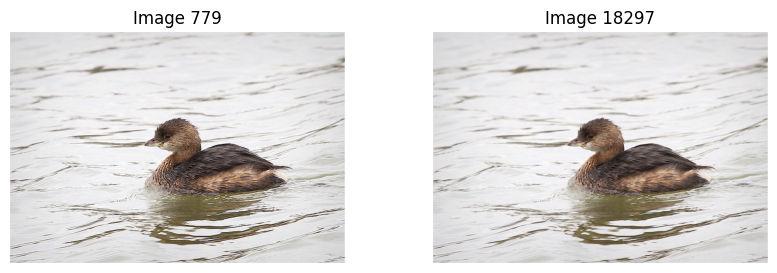

Image duplicates:


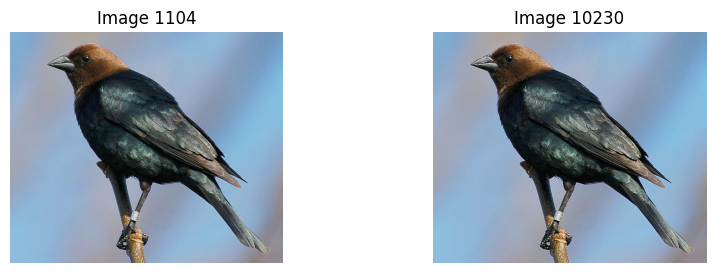

Image duplicates:


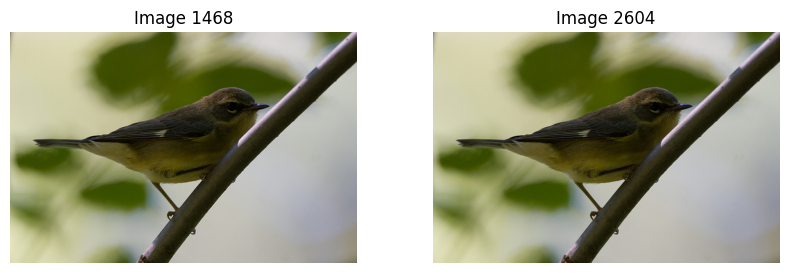

Image duplicates:


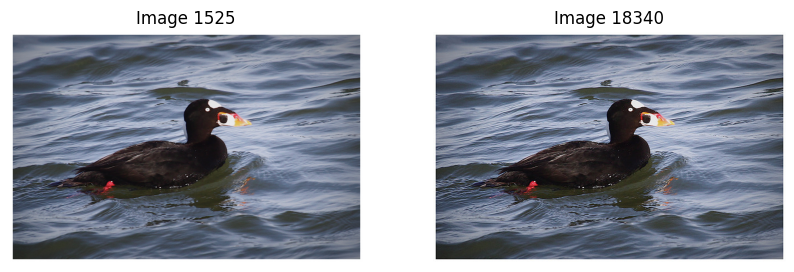

Image duplicates:


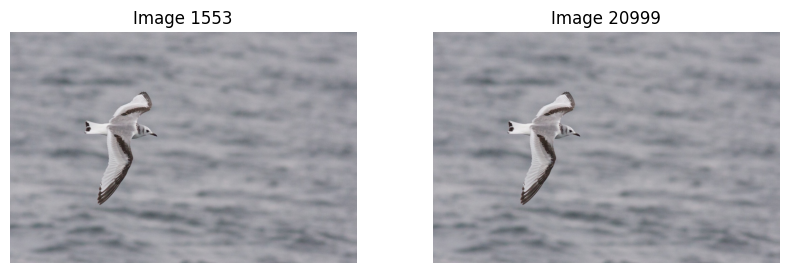

Image duplicates:


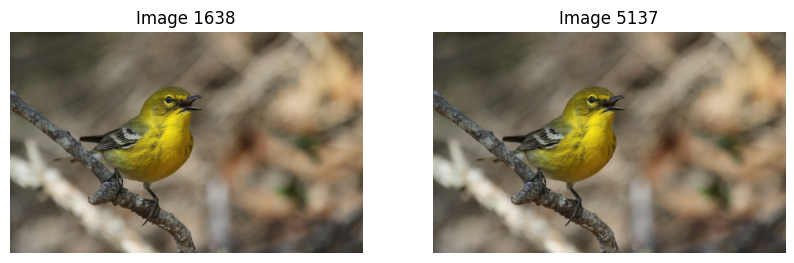

Found 64 true duplicates!


In [5]:
def resize_image(image: np.ndarray, size: tuple[int, int] = (8, 8)) -> np.ndarray:
    """
    Resize the input image to the specified size.

    Args:
        image (numpy.ndarray): The input image as a NumPy array.
        size (tuple[int, int], optional): The target size of the image. Default is (8, 8).

    Returns:
        numpy.ndarray: The resized image as a NumPy array.
    """
    pil_image = Image.fromarray(image)
    resized_image = pil_image.resize(size, Image.Resampling.LANCZOS)
    return np.array(resized_image)


def are_images_identical(
    image1: np.ndarray, image2: np.ndarray, tolerance: int = 5
) -> bool:
    """
    Check if two images are identical within a specified tolerance.

    Args:
        image1 (numpy.ndarray): The first image as a NumPy array.
        image2 (numpy.ndarray): The second image as a NumPy array.
        tolerance (int, optional): The tolerance for checking equality, default is 5.

    Returns:
        bool: True if images are identical within the tolerance, False otherwise.
    """
    return np.allclose(image1, image2, atol=tolerance)


def display_images(images: list[np.ndarray], titles: list[str] = None) -> None:
    """
    Display a list of images with optional titles.

    Args:
        images (list[numpy.ndarray]): A list of images as NumPy arrays to be displayed.
        titles (list[str], optional): A list of titles corresponding to each image. Default is None.

    Returns:
        None
    """
    plt.figure(figsize=(10, 3))

    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis("off")
    plt.show()


real_duplicates = []

for hash_value, indices in hashes.items():
    if len(indices) >= 2:
        images_to_display = [
            Image.fromarray(ds_train.images[idx].numpy()) for idx in indices
        ]
        titles = [f"Image {idx}" for idx in indices]

        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                idx1, idx2 = indices[i], indices[j]
                image1 = ds_train.images[idx1].numpy()
                image2 = ds_train.images[idx2].numpy()

                resized_image1 = resize_image(image1)
                resized_image2 = resize_image(image2)

                if are_images_identical(resized_image1, resized_image2):
                    real_duplicates.append((idx1, idx2))
                    if len(real_duplicates) <= 10:
                        print("Image duplicates:")

        if len(real_duplicates) <= 10:
            display_images(images_to_display, titles)

if real_duplicates:
    print(f"Found {len(real_duplicates)} true duplicates!")
else:
    print("No true duplicates found based on pixel comparison.")

So from 78 hash duplicates we have 64 real image duplications.      
We will filter them out during image spliting.      

### Check Image Corruption

1. Correct Shape: Ensures the image has three dimensions (Height, Width, Channels).
2. No NaN or Infinity Values: Uses np.isnan() and np.isinf() to detect invalid pixel values.
3. Non-Empty Image: If the sum of pixel values is zero, the image is considered empty/corrupt.

In [6]:
def is_valid_image(image_tensor: torch.Tensor) -> bool:
    """
    Check if the given image tensor is valid based on certain criteria.

    Args:
        image_tensor (torch.Tensor): The input image tensor.

    Returns:
        bool: True if the image tensor is valid, False otherwise.
    """
    try:
        image = image_tensor.numpy()

        if len(image.shape) != 3:
            return False

        if np.any(np.isnan(image)) or np.any(np.isinf(image)):
            return False

        if np.sum(image) == 0:
            return False

        return True
    except Exception as e:
        return False


corrupted_images = []
for i, image_tensor in enumerate(ds_train.images):
    if not is_valid_image(image_tensor):
        corrupted_images.append(i)

print(f"Found {len(corrupted_images)} corrupted images!")
print("Corrupted image indices:", corrupted_images)

corrupted_images = []
for i, image_tensor in enumerate(ds_test.images):
    if not is_valid_image(image_tensor):
        corrupted_images.append(i)

print(f"Found {len(corrupted_images)} corrupted images!")
print("Corrupted image indices:", corrupted_images)

Found 0 corrupted images!
Corrupted image indices: []
Found 0 corrupted images!
Corrupted image indices: []


There is no image corruptions.

### Check for Missing Labels

In [7]:
missing_labels = [
    i for i, label in enumerate(ds_train.labels) if label is None or label == ""
]
print(f"Number of missing labels: {len(missing_labels)}")

missing_labels = [
    i for i, label in enumerate(ds_test.labels) if label is None or label == ""
]
print(f"Number of missing labels: {len(missing_labels)}")

Number of missing labels: 0
Number of missing labels: 0


There is no missing labels.

<a id="eda"></a>
# 3. EDA

### Dataset size

In [8]:
len(ds_train.labels), len(ds_test.labels)

(23928, 24633)

Distribution between train and test equally distributed.

### Display images

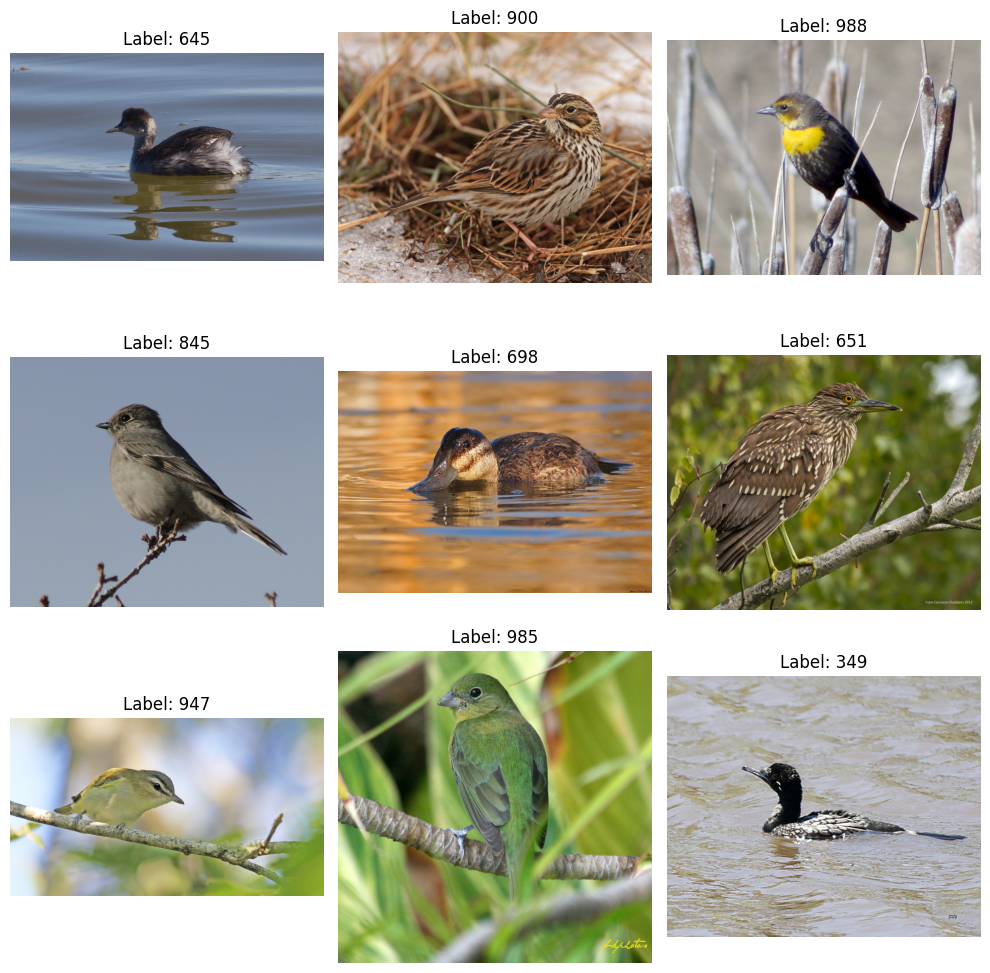

In [9]:
num_images = 9
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image = ds_train.images[i].numpy()
    label = int(ds_train.labels[i].numpy())

    ax.imshow(image)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Image shapes

In [10]:
image_shapes = [ds_train.images[i].numpy().shape for i in range(len(ds_train.images))]
shape_counts = Counter(image_shapes)

In [11]:
first_10_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("First 10 Image Shape Distributions:")
for shape, count in first_10_shapes:
    print(f"Shape {shape}: {count} images")
print("...")

First 10 Image Shape Distributions:
Shape (683, 1024, 3): 3234 images
Shape (768, 1024, 3): 1636 images
Shape (600, 800, 3): 722 images
Shape (682, 1024, 3): 603 images
Shape (680, 1024, 3): 483 images
Shape (819, 1024, 3): 475 images
Shape (533, 800, 3): 370 images
Shape (800, 800, 3): 322 images
Shape (1024, 683, 3): 315 images
Shape (681, 1024, 3): 258 images
...


In [12]:
unique_image_shapes = np.unique(image_shapes)
num_shapes = len(unique_image_shapes)

print(f"Number of distinct classes: {num_shapes}")

Number of distinct classes: 763


- We have many different shapes and most of them fit in hight: 600-800 and width: 800-1000.
- The dataset contains 763 unique image shapes.

### Labels distribution

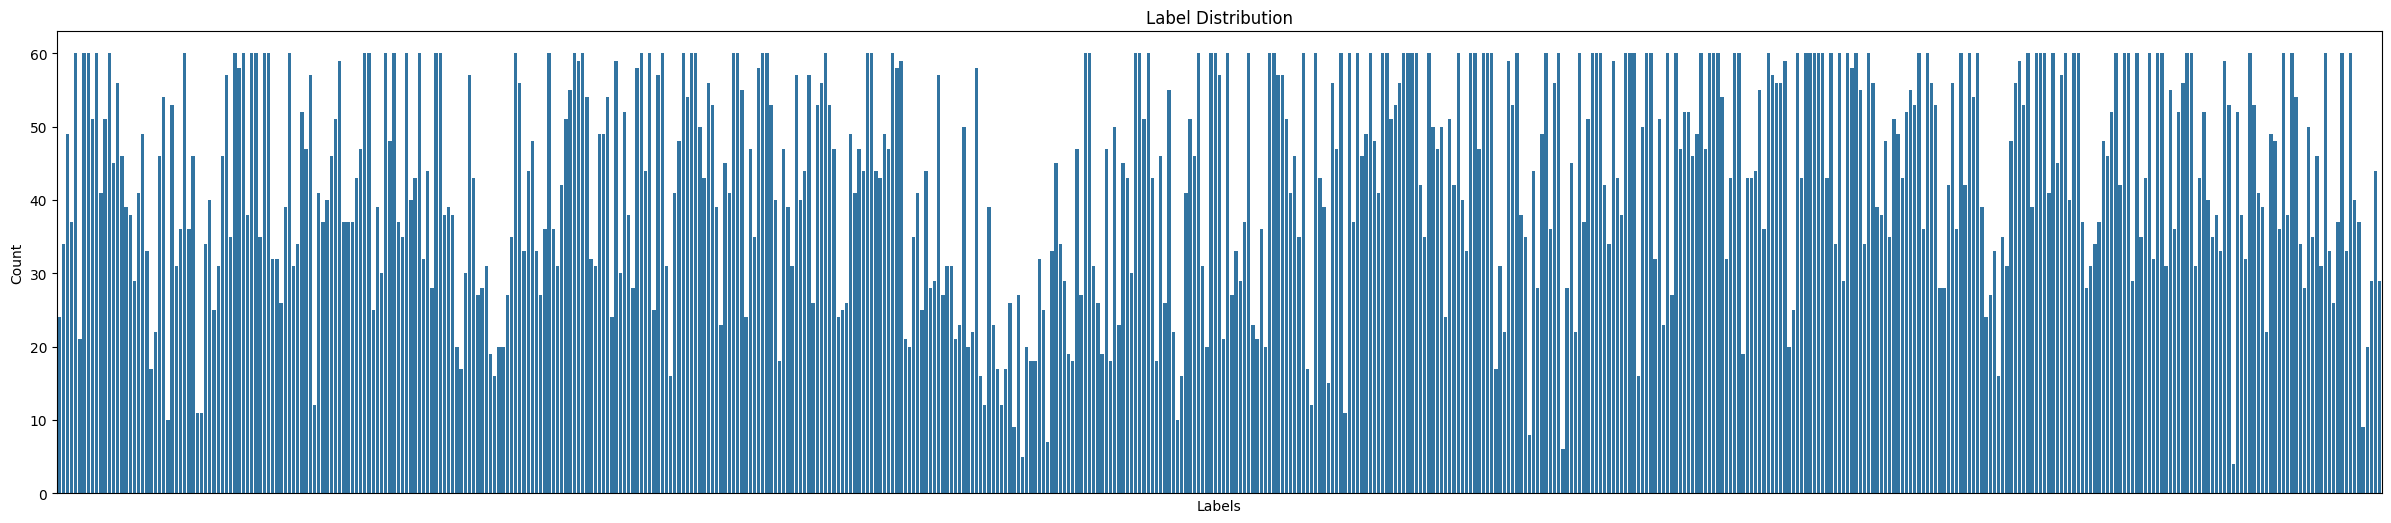

In [13]:
labels = np.ravel([ds_train.labels[i].numpy() for i in range(len(ds_train.labels))])
labels = labels.astype(int)
label_counts = Counter(labels)
labels_list = list(label_counts.keys())
counts_list = list(label_counts.values())

plt.figure(figsize=(30, 6))
sns.barplot(x=labels_list, y=counts_list)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.xticks([], [])
plt.show()

In [14]:
min_count = min(label_counts.values())
max_count = max(label_counts.values())

min_label = [label for label, count in label_counts.items() if count == min_count]
max_label = [label for label, count in label_counts.items() if count == max_count]

print(f"Minimum count: {min_count}, {len(min_label)} cases, {min_label} classes ")
print(
    f"Maximum count: {max_count}, {len(max_label)} cases, {max_label[:10]}.. classes "
)

Minimum count: 5, 1 cases, [627] classes 
Maximum count: 60, 130 cases, [900, 947, 997, 528, 766, 700, 753, 469, 949, 932].. classes 


In [15]:
unique_labels = np.unique(labels)

num_classes = len(unique_labels)

print(f"Number of distinct classes: {num_classes}")

Number of distinct classes: 555


- The dataset contains 555 distinct classes, with a varying number of samples per class.
- Minimum count: 5 samples (observed in 1 class, e.g., class 627).
- Maximum count: 60 samples (observed in 130 classes, including 900, 947, 997, 528, etc.).
- There is a imbalance, with one class having only 5 samples, while others have 60.
- Majority of classes have more then 20 images per class.
- This imbalance can cause bias in model training, favoring well-represented classes.

### Missing Classes in Label Distribution

In [16]:
labels = np.ravel([ds_train.labels[i].numpy() for i in range(len(ds_train.labels))])

label_counts = Counter(labels)

for label, count in sorted(label_counts.items())[:10]:
    print(f"Class {label}: {count} samples")
print("...")

Class 295: 24 samples
Class 296: 34 samples
Class 297: 49 samples
Class 298: 37 samples
Class 299: 60 samples
Class 313: 21 samples
Class 314: 60 samples
Class 315: 60 samples
Class 316: 51 samples
Class 317: 60 samples
...


- While analyzing the label distribution, noticed missing class labels between 299 and 313 and there is more gaps. So we will do label mapping from 0.


#### Mapping labels

In [17]:
labels_tensor = torch.tensor(ds_train.labels.numpy())
unique_labels = torch.unique(labels_tensor)

label_map = {label.item(): idx for idx, label in enumerate(unique_labels)}
for key, value in list(label_map.items())[:10]:
    print(f"From {key} class change to {value}")
print("...")

From 295 class change to 0
From 296 class change to 1
From 297 class change to 2
From 298 class change to 3
From 299 class change to 4
From 313 class change to 5
From 314 class change to 6
From 315 class change to 7
From 316 class change to 8
From 317 class change to 9
...


- Now class labels start from 0 up to 554.

<a id="split"></a>
# 4. Data Spliting

### Create list to Remove Duplicate Images

- real_duplicates - list of 2 item tuples and second item we will remove while spliting images.

In [18]:
remove_ids = [id for _, id in real_duplicates]

In [19]:
labelled_ds = deeplake.empty("data/nabirds-dataset-labelled", overwrite=True)
unlabelled_ds = deeplake.empty("data/nabirds-dataset-unlabelled", overwrite=True)
train_ds = deeplake.empty("data/nabirds-dataset-train", overwrite=True)
test_ds = deeplake.empty("data/nabirds-dataset-test", overwrite=True)

for ds in [labelled_ds, unlabelled_ds, train_ds, test_ds]:
    ds.create_tensor("images", htype="image", dtype=np.uint8, sample_compression="jpeg")
    ds.create_tensor("labels", htype="class_label", dtype=int)

class_counts = defaultdict(int)
max_images_per_class = 5


def process_dataset(source_ds: torch.utils.data.Dataset) -> None:
    """
    Processes the source dataset, mapping labels and splitting them into labeled and unlabeled datasets
    based on certain conditions. Also, updates class counts and ensures that the maximum number of
    images per class is respected.

    Args:
        source_ds (torch.utils.data.Dataset): The input dataset containing the images and their labels.

    Returns:
        None: This function modifies the global variables (`train_ds`, `labelled_ds`, `unlabelled_ds`,
        `class_counts`) in-place.
    """
    for sample in source_ds:
        label = int(sample.labels.numpy())

        if label in remove_ids:
            mapped_label = label_map[label]

            train_ds.append({"images": sample.images, "labels": mapped_label})

            if class_counts[mapped_label] < max_images_per_class:
                labelled_ds.append({"images": sample.images, "labels": mapped_label})
                class_counts[mapped_label] += 1
            else:
                unlabelled_ds.append({"images": sample.images, "labels": mapped_label})


process_dataset(ds_train)


def process_test_dataset(source_ds: torch.utils.data.Dataset) -> None:
    """
    Processes the test dataset by mapping the labels and appending them to the test dataset list.

    Args:
        source_ds (torch.utils.data.Dataset): The input test dataset containing images and labels.

    Returns:
        None: This function modifies the global variable `test_ds` in-place, appending the processed samples.
    """
    for sample in source_ds:
        label = int(sample.labels.numpy())
        mapped_label = label_map[label]
        test_ds.append({"images": sample.images, "labels": mapped_label})


process_test_dataset(ds_test)

data/nabirds-dataset-labelled loaded successfully.
data/nabirds-dataset-unlabelled loaded successfully.
data/nabirds-dataset-train loaded successfully.
data/nabirds-dataset-test loaded successfully.


Created two new datasets:
- labelled_ds: Contains a maximum of 5 images per class.
- unlabelled_ds: Stores the remaining images that exceed the limit.
- Checked if a class should be removed using remove_ids
- Mapped class labels

<a id="models"></a>
# 5. Models

<a id="few"></a>
## 5.1. Few-Shots Classification

### Image Preprocessing

- Resizing: Scaled to 224 × 224 pixels for consistency.  
- Tensor Conversion: Converted to a PyTorch tensor.  
- Normalization: Adjusted using ImageNet mean [0.485, 0.456, 0.406] and std [0.229, 0.224, 0.225] for stability.  


In [20]:
image_size = 224
transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

### Custom Dataset: DeepLakeFewShotDataset
- This dataset class wraps a DeepLake dataset for few-shot learning, applying transformations and providing labels

In [21]:
labelled_set = DeepLakeFewShotDataset(labelled_ds, transform=transform)
unlabelled_set = DeepLakeFewShotDataset(unlabelled_ds, transform=transform)
test_set = DeepLakeFewShotDataset(test_ds, transform=transform)

### CustomTaskSampler
- labelled_sampler - 10-way, 2-shot, 3-query, 50 tasks for training. Max we can have 5 images (shot + query), because dataset contains only 5 images per class.
- unlabelled_sampler - 10-way, 2-shot, 3-query, 50 tasks for infering. 
- test_sampler - 5-way, 5-shot, 5-query, 50 tasks for testing.

In [22]:
labelled_sampler = CustomTaskSampler(
    labelled_set, n_way=10, n_shot=2, n_query=3, n_tasks=200
)
unlabelled_sampler = CustomTaskSampler(
    unlabelled_set, n_way=10, n_shot=2, n_query=3, n_tasks=50
)
test_sampler = CustomTaskSampler(test_set, n_way=5, n_shot=5, n_query=5, n_tasks=50)

### Create DataLoaders

In [23]:
train_loader = DataLoader(
    labelled_set,
    batch_sampler=labelled_sampler,
    num_workers=4,
    collate_fn=labelled_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    unlabelled_set,
    batch_sampler=unlabelled_sampler,
    num_workers=4,
    collate_fn=unlabelled_sampler.episodic_collate_fn,
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=4,
    collate_fn=test_sampler.episodic_collate_fn,
)

### Prototypical Networks

The PrototypicalNetworks class defines a prototypical network model for few-shot learning. It leverages a backbone model (such as ResNet-18) to extract features from support and query images, and computes distances between the query image embeddings and class prototypes.

In [24]:
class PrototypicalNetworks(nn.Module):
    """
    Prototypical Networks for few-shot learning.

    This class implements the Prototypical Networks architecture, which is used for few-shot classification.
    It leverages a backbone network to extract features from both support and query images, computes the
    class prototypes for the support set, and then computes the distances between the query set and these prototypes.

    Args:
        backbone (nn.Module): The neural network backbone used to extract features from the input images.

    Methods:
        forward(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
            Forward pass through the network. Given support images and labels, and query images, it computes
            the distance between the query features and the class prototypes derived from the support set.
    """

    def __init__(self, backbone: nn.Module) -> None:
        """
        Initializes the Prototypical Networks model.

        Args:
            backbone (nn.Module): The neural network backbone to extract features.
        """
        super().__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Forward pass through the model.

        Args:
            support_images (torch.Tensor): The support images.
            support_labels (torch.Tensor): The corresponding labels for the support images.
            query_images (torch.Tensor): The query images for which predictions are to be made.

        Returns:
            torch.Tensor: The negative pairwise distance between the query features and class prototypes.
        """
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)
        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat(
            [
                z_support[support_labels == label].mean(0, keepdim=True)
                for label in range(n_way)
            ]
        )
        dists = torch.cdist(z_query, z_proto)
        return -dists


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = resnet18(pretrained=True)
backbone.fc = nn.Flatten()
model = PrototypicalNetworks(backbone)
model = model.to(device)

### Loss Function and Optimizer

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Function

The train function is responsible for training the Prototypical Networks model using the provided training data.   
Each batch in train_loader provides 6 data lists: support images/labels, query images/labels, indexes of query images and true class ids. 

In [26]:
def train():
    model.train()
    total_loss = 0
    for (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
        _,
    ) in train_loader:
        optimizer.zero_grad()
        scores = model(
            support_images.to(device),
            support_labels.to(device),
            query_images.to(device),
        )
        loss = criterion(scores, query_labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

### Evaluation Function

The evaluate function is used to assess the performance of the Prototypical Networks model on the validation dataset. It calculates the accuracy and identifies high-confidence predictions where the model is very certain about its predictions.  
List `query_ids` is used to store image id's from val_loader where we got good predictions with 95% confident on image. Then those images latter will be added to training set.

In [27]:
def evaluate() -> None:
    """
    Evaluates the model on the validation dataset.

    This function performs the evaluation of the Prototypical Networks model on a validation set, computing
    the accuracy and identifying high-confidence correct predictions. It tracks the correct query IDs,
    predicted labels, and true labels for those predictions with a confidence greater than a specified threshold.

    Returns:
        None
    """
    model.eval()
    correct, total = 0, 0
    correct_query_ids = []
    high_confidence_preds = []
    high_confidence_labels = []
    confidence_threshold = 0.95

    with torch.no_grad():
        for (
            support_images,
            support_labels,
            query_images,
            query_labels,
            query_ids,
            _,
        ) in val_loader:
            scores = model(
                support_images.to(device),
                support_labels.to(device),
                query_images.to(device),
            )

            probabilities = F.softmax(scores, dim=1)

            max_probs, predictions = probabilities.max(dim=1)

            correct += (predictions == query_labels).sum().item()
            total += query_labels.size(0)

            for i in range(len(query_ids)):
                if (
                    predictions[i] == query_labels[i]
                    and max_probs[i] > confidence_threshold
                ):
                    correct_query_ids.append(query_ids[i])
                    high_confidence_preds.append(predictions[i].item())
                    high_confidence_labels.append(query_labels[i].item())

    return (
        correct / total,
        correct_query_ids,
        high_confidence_preds,
        high_confidence_labels,
    )

### Test Function

In [28]:
def test() -> float:
    """
    Tests the model on the test dataset.

    This function performs evaluation on the test set by making predictions on the query images and comparing
    them with the true labels. It tracks the accuracy and stores the query IDs of correctly classified samples.

    Returns:
        float: The accuracy of the model on the test dataset.
    """
    model.eval()
    correct, total = 0, 0
    correct_query_ids = []

    with torch.no_grad():
        for (
            support_images,
            support_labels,
            query_images,
            query_labels,
            query_ids,
            _,
        ) in test_loader:
            scores = model(
                support_images.to(device),
                support_labels.to(device),
                query_images.to(device),
            )
            predictions = scores.argmax(dim=1)

            correct_mask = predictions == query_labels
            correct_query_ids.extend(
                [query_ids[i] for i in range(len(query_ids)) if correct_mask[i]]
            )

            correct += (predictions == query_labels.to(device)).sum().item()
            total += query_labels.size(0)
    return correct / total

### Training and Evaluation Results

In [29]:
all_correct_query_ids = []
all_high_confidence_preds = []
all_high_confidence_labels = []

for epoch in range(5):
    loss = train()
    accuracy, correct_query_ids, high_confidence_preds, high_confidence_labels = (
        evaluate()
    )
    all_correct_query_ids.extend(correct_query_ids)
    all_high_confidence_preds.extend(high_confidence_preds)
    all_high_confidence_labels.extend(high_confidence_labels)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={accuracy:.2%}")

test_accuracy = test()
print(f"Accuracy={test_accuracy:.2%}")

Epoch 1: Loss=0.4031, Accuracy=49.33%
Epoch 2: Loss=0.1227, Accuracy=51.53%
Epoch 3: Loss=0.0406, Accuracy=49.53%
Epoch 4: Loss=0.0179, Accuracy=50.07%
Epoch 5: Loss=0.0136, Accuracy=48.93%
Accuracy=68.80%


- The model showed an improvement in loss during the initial epochs but then stabilized, with slight fluctuations in accuracy in later epochs.
- The final test accuracy of 68.80% is a decent result for a few-shot learning task, where the model's ability to generalize from a limited number of samples is being tested.
- The loss decreased progressively, indicating the model is learning to fit the data. However, the accuracy did not consistently increase in the last few epochs, which suggests the model might be nearing its performance limit on this specific dataset.
- Additionay Unlabelled Sampler provides n_shot=2 and n_query=3 images where Test Sampler provides n_shot=5 and n_query=5, so we should not compare accuracy on Unlabelled and Test data. 

### Display good predictions

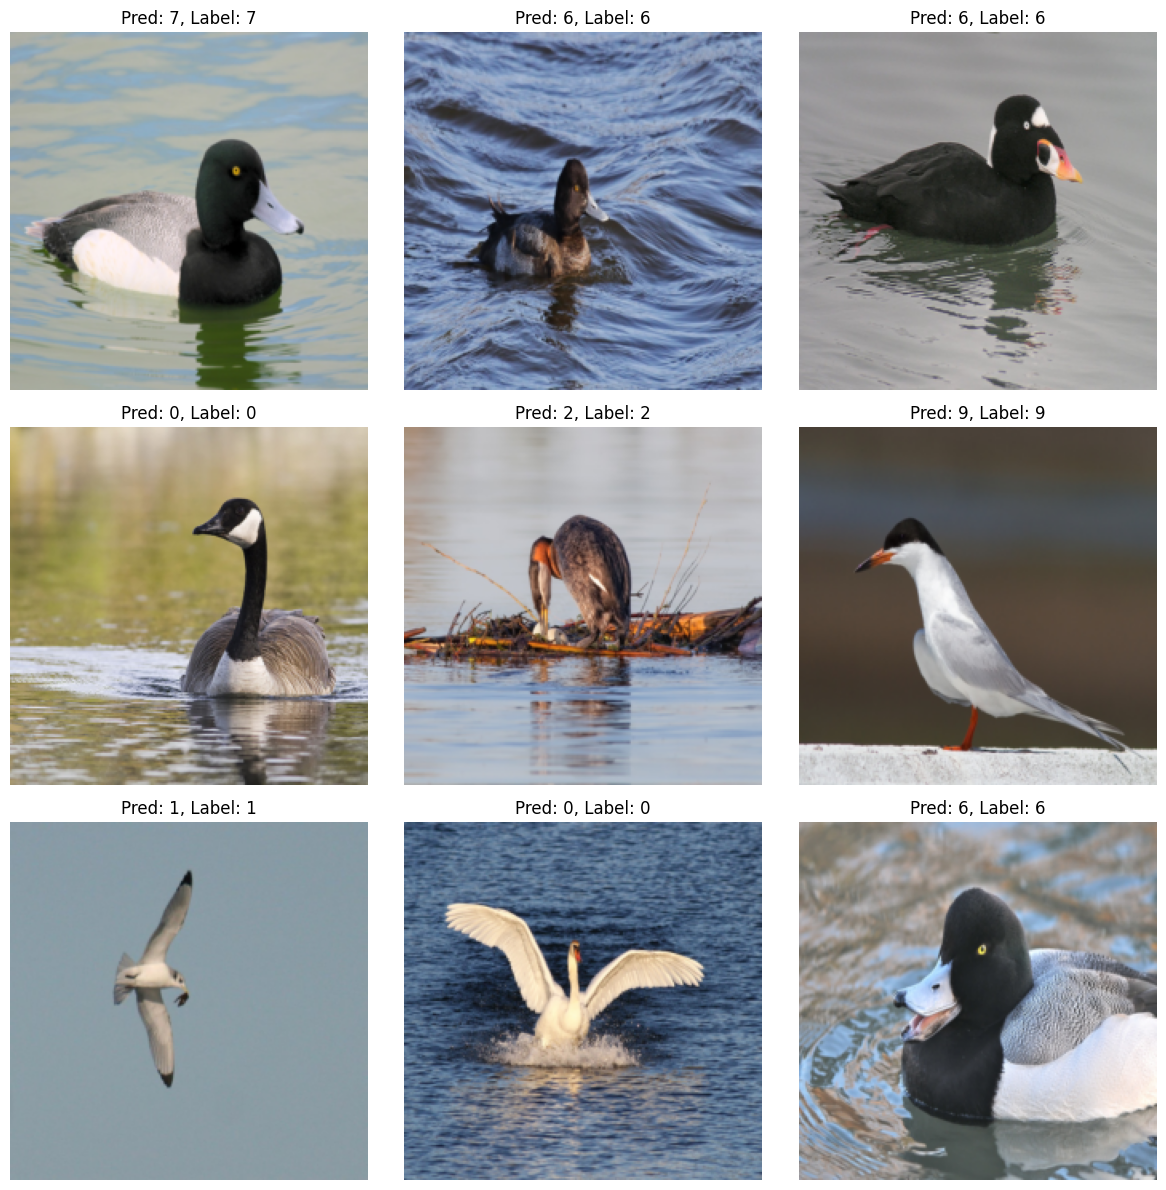

In [30]:
num_samples_to_display = 9


def reverse_normalize(
    tensor: torch.Tensor, mean: torch.Tensor, std: torch.Tensor
) -> torch.Tensor:
    """
    Reverses the normalization transformation applied to an image tensor.

    This function scales and shifts the tensor values back to their original range by using the provided
    mean and standard deviation values. The transformation is performed element-wise for each channel.

    Args:
        tensor (torch.Tensor): The normalized image tensor.
        mean (torch.Tensor): The mean values used during the normalization.
        std (torch.Tensor): The standard deviation values used during the normalization.

    Returns:
        torch.Tensor: The tensor with reversed normalization.
    """
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

indices = np.random.choice(
    len(all_correct_query_ids), num_samples_to_display, replace=False
)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, idx in enumerate(indices):
    query_id = int(all_correct_query_ids[idx])
    image_tensor = unlabelled_set[query_id][0]

    image_tensor = reverse_normalize(image_tensor, mean, std)

    image_np = image_tensor.permute(1, 2, 0).to(device).numpy()

    axes[i].imshow(image_np)
    axes[i].axis("off")

    predicted_label = all_high_confidence_preds[idx]
    true_label = all_high_confidence_labels[idx]
    axes[i].set_title(f"Pred: {predicted_label}, Label: {true_label}")

plt.tight_layout()
plt.show()

### Add Images from Unlabelled Set to Labelled Set
Good predictions from Unlabelled Sampler will be added to Labelled Sampler.

In [31]:
correct_query_unique_ids = list(set(all_correct_query_ids))

correct_images = [unlabelled_set.ds[idx] for idx in correct_query_unique_ids]

for data in correct_images:
    image = data["images"]
    label = data["labels"]
    labelled_set.ds.append({"images": image, "labels": label})

### Recreate DataLoader with New Labelled Set

In [32]:
train_sampler = CustomTaskSampler(
    labelled_set, n_way=5, n_shot=2, n_query=4, n_tasks=10
)

train_loader = DataLoader(
    labelled_set,
    batch_sampler=labelled_sampler,
    num_workers=4,
    collate_fn=labelled_sampler.episodic_collate_fn,
)

### Second Iteration - Training with a Different Labelled Set

In [33]:
all_correct_query_ids = []
all_high_confidence_preds = []
all_high_confidence_labels = []

for epoch in range(5):
    loss = train()
    accuracy, correct_query_ids, high_confidence_preds, high_confidence_labels = (
        evaluate()
    )
    all_correct_query_ids.extend(correct_query_ids)
    all_high_confidence_preds.extend(high_confidence_preds)
    all_high_confidence_labels.extend(high_confidence_labels)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={accuracy:.2%}")

test_accuracy = test()
print(f"Accuracy={test_accuracy:.2%}")

Epoch 1: Loss=0.1857, Accuracy=38.87%
Epoch 2: Loss=0.0337, Accuracy=48.33%
Epoch 3: Loss=0.0035, Accuracy=49.93%
Epoch 4: Loss=0.0007, Accuracy=49.93%
Epoch 5: Loss=0.0017, Accuracy=53.33%
Accuracy=73.92%


- The model demonstrated rapid improvement during the first few epochs in terms of both loss and accuracy.
- The loss decreased after the first epoch, and accuracy progressively improved, indicating the model was adapting well to the new labelled set.
- The accuracy improved notably in the second iteration, reaching 73.92% compared with first iteration with accuracy 68.80%.

### Save model

In [34]:
torch.save(model.state_dict(), "models/prototypical_network.pth")

<a id="pretrained"></a>
## 5.2. Classification Using Pre-trained Architecture With Fine-Tuning

### Image Preprocessing

- Resizing: Scaled to 224 × 224 pixels for consistency.  
- Tensor Conversion: Converted to a PyTorch tensor.  
- Normalization: Adjusted using ImageNet mean [0.485, 0.456, 0.406] and std [0.229, 0.224, 0.225] for stability.  


In [35]:
image_size = 224
transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

### Create DataLoaders

In [36]:
train_set = DeepLakeFewShotDataset(train_ds, transform=transform)
test_set = DeepLakeFewShotDataset(test_ds, transform=transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

### Prepare ResNet-18 architecture
Set up the model using a pre-trained ResNet-18 architecture. The final fully connected layer model.fc is modified to match the number of classes in the dataset. 


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(set(int(train_ds[i]["labels"].numpy()) for i in range(len(train_ds))))

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

### Loss Function and Optimizer

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

### Classifier Head Training with Early Stopping and Model Saving

In this cell, the classifier head is trained with early stopping implemented to prevent overfitting. The backbone of the pre-trained model is frozen by setting requires_grad = False for the initial convolution layers. The training process runs for a maximum of 10 epochs but will stop earlier if the validation loss does not improve for 3 consecutive epochs (patience of 3). The model with the best validation loss is saved to a file.

In [39]:
def train_classifier_head(epochs: int = 5) -> None:
    """
    Trains the classifier head of the model using the provided training dataset.

    This function freezes the backbone of the model, trains the classifier head using the given
    training data, and applies early stopping to prevent overfitting. The best model is saved
    based on the lowest validation loss during training.

    Args:
        epochs (int): The number of epochs to train the classifier head. Default is 5.

    Returns:
        None: The model is trained in-place, and the best model is saved to disk.
    """
    patience = 3
    best_val_loss = np.inf
    early_stop_counter = 0
    save_path = "models/best_model_head.pth"
    loss_list = []

    print("Training classifier head...")

    # Freeze backbone
    for param in model.conv1.parameters():
        param.requires_grad = False

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        loss_list.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}")

        if avg_train_loss < best_val_loss:
            best_val_loss = avg_train_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            early_stop_counter += 1

        if early_stop_counter > patience:
            print("Early stopping triggered! Stopping training.")
            break

    print(f"Model saved at {save_path} (Best Val Loss: {best_val_loss:.4f})")


train_classifier_head(epochs=10)

Training classifier head...
Epoch 1/10, Loss: 2.5732
Epoch 2/10, Loss: 0.8907
Epoch 3/10, Loss: 0.3442
Epoch 4/10, Loss: 0.1028
Epoch 5/10, Loss: 0.0315
Epoch 6/10, Loss: 0.0133
Epoch 7/10, Loss: 0.0087
Epoch 8/10, Loss: 0.0068
Epoch 9/10, Loss: 0.0057
Epoch 10/10, Loss: 0.0051
Model saved at models/best_model_head.pth (Best Val Loss: 0.0051)


- The training loss steadily decreased over the epochs.
- The best model (with the lowest validation loss) was saved after epoch 10 with a final loss of 0.0051.

### Fine-Tuning the Whole Model

In this step, the entire model (including both the backbone and classifier head) is fine-tuned using the SGD optimizer and smaller learning rate when in Head training. The model training involves unfreezing all the layers, which means the backbone is also trained along with the classifier head.

In [40]:
def fine_tune(epochs: int = 5) -> None:
    """
    Fine-tunes the entire model, including both the backbone and classifier head, using the provided training dataset.

    This function unfreezes all layers of the model, allowing them to be updated during training. It applies early
    stopping based on the validation loss and saves the best model during the training process.

    Args:
        epochs (int): The number of epochs to fine-tune the model. Default is 5.

    Returns:
        None: The model is fine-tuned in-place, and the best model is saved to disk.
    """
    patience = 3
    best_val_loss = np.inf
    early_stop_counter = 0
    save_path = "models/best_model_whole.pth"
    loss_list = []

    print("Fine-tuning the whole model...")

    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        loss_list.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}")

        if avg_train_loss < best_val_loss:
            best_val_loss = avg_train_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            early_stop_counter += 1

        if early_stop_counter > patience:
            print("Early stopping triggered! Stopping training.")
            break

    print(f"Model saved at {save_path} (Best Val Loss: {best_val_loss:.4f})")


fine_tune(epochs=10)

Fine-tuning the whole model...
Epoch 1/10, Loss: 0.0043
Epoch 2/10, Loss: 0.0042
Epoch 3/10, Loss: 0.0042
Epoch 4/10, Loss: 0.0043
Early stop counter: 1/3
Epoch 5/10, Loss: 0.0041
Epoch 6/10, Loss: 0.0041
Epoch 7/10, Loss: 0.0042
Early stop counter: 1/3
Epoch 8/10, Loss: 0.0039
Epoch 9/10, Loss: 0.0039
Early stop counter: 1/3
Epoch 10/10, Loss: 0.0039
Model saved at models/best_model_whole.pth (Best Val Loss: 0.0039)


- The training loss consistently decreased over the epochs.
- The best model (with the lowest validation loss) was saved at the end of training with a final loss of 0.0039.

### Model Testing and Evaluation

In [41]:
def test() -> tuple:
    """
    Evaluates the model's performance on the test dataset by calculating the overall accuracy and the accuracy for each class.

    This function computes the overall test accuracy and also calculates the class-specific accuracy, identifying the
    top 5 best predicted classes and the top 5 worst predicted classes based on accuracy.

    Returns:
        tuple: A tuple containing two lists:
            - `best_classes` (list): The top 5 best predicted classes along with their accuracy.
            - `worst_classes` (list): The top 5 worst predicted classes along with their accuracy.
    """
    model.eval()
    correct, total = 0, 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predictions = outputs.argmax(dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            for label, pred in zip(labels, predictions):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2%}")

    class_accuracies = {
        cls: class_correct[cls] / class_total[cls]
        for cls in class_total
        if class_total[cls] > 0
    }

    sorted_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

    best_classes = sorted_classes[:5]
    worst_classes = sorted_classes[-5:]

    print("\nTop 5 Best Predicted Classes:")
    for cls, acc in best_classes:
        print(f"Class {cls}: {acc:.2%} accuracy")

    print("\nTop 5 Worst Predicted Classes:")
    for cls, acc in worst_classes:
        print(f"Class {cls}: {acc:.2%} accuracy")

    return best_classes, worst_classes


best_classes, worst_classes = test()

Test Accuracy: 72.28%

Top 5 Best Predicted Classes:
Class 30: 100.00% accuracy
Class 31: 100.00% accuracy
Class 73: 96.61% accuracy
Class 46: 94.83% accuracy
Class 59: 94.29% accuracy

Top 5 Worst Predicted Classes:
Class 77: 39.13% accuracy
Class 75: 35.00% accuracy
Class 82: 29.27% accuracy
Class 48: 23.33% accuracy
Class 26: 14.29% accuracy


- The model’s overall test accuracy of 72.28% indicates a relatively strong performance. 
- Several classes are predicted with 94% or higher accuracy suggests the model has learned strong general features for certain categories.
- The significant drop-off in performance for certain classes suggests areas where the model might need more specific attention and additional data.

<a id="comparison"></a>
## 5.3. Few-Shots Classification and Classification with Fine-Tuning Comparison

#### 1. Few-Shot Classification (Accuracy: 73.92%):
   - Approach: Few-shot learning techniques aim to classify new classes with very few labeled samples focusing on generalizing the learned knowledge to make predictions with limited data.
   - Performance: 
     - Accuracy (73.92%) indicates a relatively strong performance in situations where there are limited training examples per class.
     - Strengths:
       - The model excels in generalizing to unseen classes, suggesting the few-shot strategy works well on this data.
     - Weaknesses:
       - The accuracy is slightly higher than the pre-trained model, but it is still relatively modest. This could be due to limitations in the few-shot approach, especially when data from the target domain has a high variance.
       - The model’s performance may be sensitive to hyperparameters such as n_way, n_shot, or n_query, making the system somewhat fragile and dependent on these configurations.

#### 2. Classification Using Pre-trained Architecture (Accuracy: 72.28%):
   - Approach: This method involves using a pre-trained architecture (e.g., ResNet-18, a popular CNN architecture) as the backbone and then fine-tuning it on the dataset.
     - Fine-tuning the classifier head.
     - Freezing the backbone and training the classifier head initially, followed by fine-tuning the entire model.
   - Performance:
     - Accuracy (72.28%) is slightly lower than the few-shot method but still demonstrates good performance.
     - Strengths:
       - The pre-trained model benefits from the knowledge learned from a large and diverse dataset (like ImageNet), which makes it a strong candidate for general tasks.
     - Weaknesses:
       - Even after fine-tuning, it has a slightly lower performance compared to the few-shot model. This could suggest that the pre-trained model does not perform as well when specialized fine-tuning is required for specific tasks like bird classification with a few labeled examples.


#### Conclusion:
- Few-shot classification (73.92%) slightly outperforms pre-trained architecture classification (72.28%) on this task. This result suggests that the few-shot approach is more suited for situations with limited labeled data, as it can generalize well even from fewer samples.
- However, the pre-trained architecture still delivers competitive results and could be more reliable with more data, as it leverages prior knowledge from large datasets.
- Both approaches are strong in different situations. If there is limited labeled data, the few-shot model might be preferable because it predicts only from support images and uses very few labeled examples to classify unseen data. But pre-trained model could offer better generalization and more flexibility in handling diverse classes, as it predicts across all labels.

<a id="line"></a>
## 5.4. Understand Classifier with LIME


### Take best and worst class labels

In [42]:
best_class = best_classes[0][0]
worst_class = worst_classes[0][0]

### Get One for best and worst class

In [43]:
best_sample_idx = next(
    i for i in range(len(test_ds)) if test_ds[i]["labels"].numpy() == best_class
)
worst_sample_idx = next(
    i for i in range(len(test_ds)) if test_ds[i]["labels"].numpy() == worst_class
)

best_image = test_ds[best_sample_idx]["images"].numpy()
worst_image = test_ds[worst_sample_idx]["images"].numpy()


def tensor_to_numpy(image_tensor: torch.Tensor) -> np.ndarray:
    """
    Converts a PyTorch tensor representing an image to a NumPy array.

    This function assumes that the input tensor has the shape (C, H, W) where C is the number of channels,
    H is the height, and W is the width. The tensor is permuted to the shape (H, W, C) to match the standard
    image representation before converting to a NumPy array.

    Args:
        image_tensor (torch.Tensor): A tensor representing an image in the form (C, H, W).

    Returns:
        np.ndarray: The image converted to a NumPy array with shape (H, W, C).
    """
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.permute(1, 2, 0).to(device).numpy()

    return image_tensor


best_image_np = tensor_to_numpy(best_image)
worst_image_np = tensor_to_numpy(worst_image)

### Interpret with LIME
LIME (Local Interpretable Model-Agnostic Explanations) is used here to interpret how the model makes predictions. It generates a local explanation by approximating the model's behavior around a given prediction.

100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


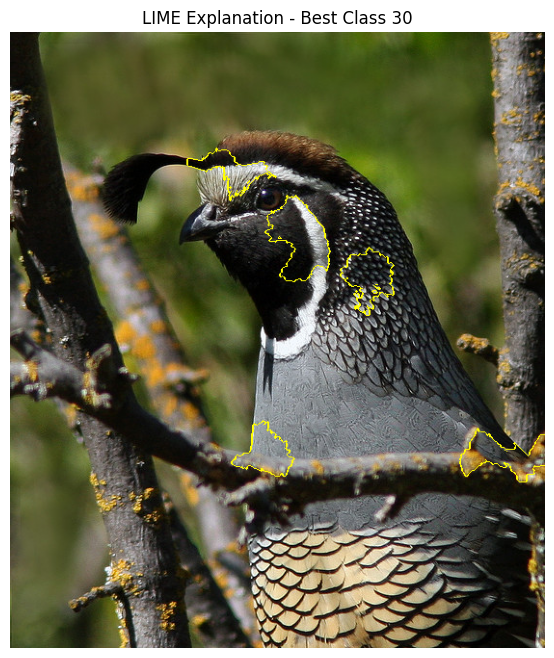

100%|██████████| 1000/1000 [10:24<00:00,  1.60it/s]


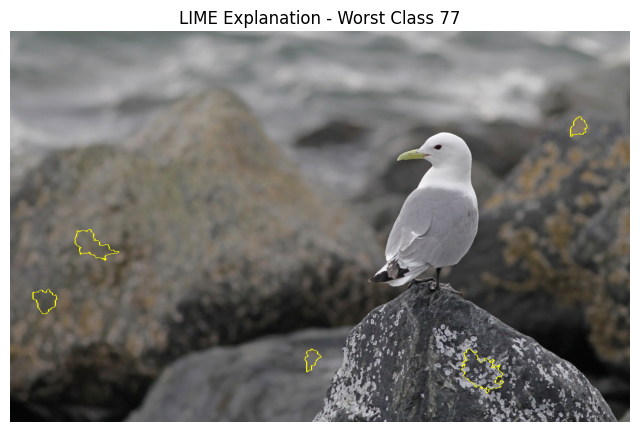

In [44]:
explainer = lime_image.LimeImageExplainer()


def predict_fn(images: list) -> np.ndarray:
    """
    Makes predictions on a list of images using the trained model.

    This function takes a list of images, converts them to tensors, feeds them through the model, and
    returns the predicted probabilities for each class.

    Args:
        images (list): A list of images to predict. Each image should be in a format that can be converted
                       into a PyTorch tensor (e.g., PIL Image).

    Returns:
        np.ndarray: The predicted probabilities for each image, with shape (num_images, num_classes).
    """
    model.eval()

    images_tensor = torch.stack([transforms.ToTensor()(img) for img in images]).to(
        device
    )

    with torch.no_grad():
        outputs = model(images_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1).to(device).numpy()

    return probs


def explain_with_lime(image: np.ndarray, title: str) -> None:
    """
    Explains a prediction for an image using LIME (Local Interpretable Model-Agnostic Explanations).

    This function explains the model's prediction for a given image by generating a visualization that
    shows the most important features used by the model to make its prediction.

    Args:
        image (np.ndarray): The image for which the explanation is generated.
        title (str): The title of the explanation plot.

    Returns:
        None
    """
    explanation = explainer.explain_instance(
        image, predict_fn, top_labels=5, hide_color=0, num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis("off")
    plt.title(title)
    plt.show()


explain_with_lime(best_image_np, f"LIME Explanation - Best Class {best_class}")
explain_with_lime(worst_image_np, f"LIME Explanation - Worst Class {worst_class}")

Best Prediction:
- Explanation: In the image with the best prediction, the areas highlighted by LIME correspond closely to parts of the bird itself. This suggests that the model is focusing on the relevant features of the bird, such as its shape, texture, and other distinct characteristics that are important for classification. The high confidence in the prediction reflects the model's ability to correctly identify and localize the relevant features.

Worst Prediction:
- Explanation: In contrast, the worst prediction shows that the areas identified by LIME are not related to the bird itself. Instead, the model is focusing on parts of the image that are irrelevant or potentially misleading, such as background elements, objects, or other non-bird features. This misfocus indicates that the model might be confusing certain visual patterns or relying on spurious correlations.

<a id="conclusion"></a>
# 6. Conclusion

- Data Issues:
  - Duplicates: We encountered 78 hash duplicates, with 64 real image duplications. Handling these duplications was essential to avoid biased training, ensuring the model learned to generalize well rather than memorizing repeated instances.
  - Imbalanced Dataset: The dataset displayed significant class imbalance, with class samples ranging from 5 to 60. This imbalance can affect the model's ability to generalize across all classes, as some classes may dominate the training process.
  - Label Gaps: There were gaps in the labels, meaning some labels were missing from the dataset, leading to incomplete representations for certain species. This could potentially hinder the model's ability to classify some bird species.

- Data Split:
  - The dataset was split into labelled and unlabelled sets. This allowed us to test few-shot learning methods, where the model learns from a small number of labeled examples for each class.

- Classifier Comparisons:
  - Two different classifiers were created:
    1. Few-shot Classifier: This classifier achieved an accuracy of 73.92%. It used a small number of labeled samples per class, which is a typical approach when dealing with few labeled data.
    2. Pre-trained Classifier with Fine-tuning: This model, fine-tuned using a pre-trained architecture, achieved a test accuracy of 72.28%. This approach leveraged the knowledge from a pre-trained model, adapting it to the bird species classification task.
    
    Comparison: Both classifiers performed similarly, though they used different techniques. While the few-shot classifier focused on learning from limited labeled samples, the pre-trained model leveraged existing knowledge from large datasets and fine-tuned it for the task. Since these methods are based on fundamentally different approaches, comparing their performance directly is not entirely fair. However, both showed comparable accuracy on the task, demonstrating the effectiveness of both methods in bird species classification.

- LIME Interpretability:
  - LIME was used to explain the model's predictions by highlighting areas of the image that contributed to the final decision. The results revealed that in best predictions, the model correctly focused on relevant parts of the bird. In contrast, for worst predictions, the model did not focus on the bird itself, but rather on irrelevant areas of the image.
  
  Insight: LIME helped identify that, in some cases, the model failed to identify the bird and instead relied on non-relevant features or background noise. This issue needs further refinement and could be addressed by improving the dataset, enhancing feature extraction, or applying more advanced techniques to focus the model on key features.

In conclusion, the project demonstrated two effective approaches to bird species classification, but also highlighted areas for improvement in both data handling and model interpretation. Further work could focus on addressing dataset imbalance, label gaps, and improving the model's focus on relevant features.
